In [1]:
## Created on Sun, Sep 30, 2018
## @ Author: Harry Zhao

## Identify Trending Words from time-stamped text list

### Assumptions & Method:

1. Only focus on English content (same algorithm can be applied to other languages)
2. Keywords normalized using word count vs. total word count in each time window
3. Use sliding observation-window identified by equal number of articles (~30)
4. "Trend" need to meet the following onditions to remove noise:  
    a. increase of "normalized frequency" from previous period (t-2 to t-1 and t-1 to t)   
    b. "normalized frequency" above unconditional mean
    c. show up in at least three consecutive time window

In [2]:
import pandas as pd
import numpy as np
import datetime
import xlrd
from collections import Counter
import matplotlib as plt

### Load and Clean data

In [3]:
# Excel file preprocessed manually by removing rows without "Time" column
text_table = pd.read_excel('rna002_RTRS_2017_11_29.xlsx') 
print(text_table.shape)
print(text_table.columns)
# remove rows that indicates "please ignore"
text_table = text_table[text_table.HEADLINE_ALERT_TEXT.str.contains("Test, Please Ignore")==False]

print(text_table.shape)
text_table.LANGUAGE.value_counts()

(8137, 19)
Index(['DATE', 'TIME', 'UNIQUE_STORY_INDEX', 'EVENT_TYPE', 'PNAC',
       'STORY_DATE_TIME', 'TAKE_DATE_TIME', 'HEADLINE_ALERT_TEXT',
       'ACCUMULATED_STORY_TEXT', 'TAKE_TEXT', 'PRODUCTS', 'TOPICS',
       'RELATED_RICS', 'NAMED_ITEMS', 'HEADLINE_SUBTYPE', 'STORY_TYPE',
       'TABULAR_FLAG', 'ATTRIBUTION', 'LANGUAGE'],
      dtype='object')
(6542, 19)


EN    3137
AR     736
FR     584
ZH     518
JA     460
DE     270
KO     266
ES     205
TH     204
PT      69
RU      39
TR      18
PL      16
NO      10
SV       2
DA       2
Name: LANGUAGE, dtype: int64

#### Most documents are in English, so focus on it first

In [4]:
text_table = text_table[text_table['LANGUAGE']=='EN']

In [5]:
## Use Headline when no Take Text is available

text_table.loc[text_table['TAKE_TEXT'].isnull(),'TAKE_TEXT'] = text_table.loc[text_table['TAKE_TEXT'].isnull(),'HEADLINE_ALERT_TEXT']

## Some format cleaning characters

text_table.TAKE_TEXT.str.replace('(','').replace(')','').replace(',','').replace('\n',' ').replace('-','')

text_table.TAKE_TEXT = text_table.TAKE_TEXT.str.replace('\n','').str.replace('(','').\
                    str.replace(')','').str.replace('>','').str.replace('<','').\
                    str.replace('*','').str.replace('.','').str.replace(';','').\
                    str.replace('+','').str.replace('\'s','').str.replace('+','\'t').\
                    str.replace('\'ve','').str.replace('"','').str.replace(',','').\
                    str.replace(':','').str.replace('_','').str.replace('-','').\
                    str.replace('/','').str.replace('[','').str.replace(']','').\
                    str.replace('|','').str.replace('#','').str.replace('"','').\
                    str.replace(',','').str.replace('=','').str.lower()

text_table = text_table[text_table["TAKE_TEXT"].notnull()]

text_table['TAKE_TEXT'] = text_table['TAKE_TEXT'].apply(lambda x: x.split())

#### Further cleaning by removing stopwords and numbers

In [6]:
# import stopwords from excel based on http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words
stopwordsList = pd.read_excel('stopwords.xlsx')

def removeStopwords(paragraphs, stopwords):
    new_paragraphs = paragraphs
    for w in stopwords:
        new_paragraphs= list(filter(lambda a: a != w, new_paragraphs))
        new_paragraphs= list(filter(str.islower, new_paragraphs))
    return new_paragraphs

text_table['TAKE_TEXT'] = text_table['TAKE_TEXT'].apply(lambda x: removeStopwords(x, stopwordsList['stopwords']))

#text_table['TAKE_TEXT'].iloc[1]
#list(filter(str.islower, text_table['TAKE_TEXT'].iloc[1]))

### Generate time window, and count words in each window

Pandas is not efficient since most entries are 0, instead using Counter for improvement

In [7]:
# text_table_in_word = text_table
# for keys, value in full_dict.items():
#     text_table_in_word[keys] = text_table_in_word.TAKE_TEXT.apply(lambda x: x.count(value))
text_table['word_count'] =  text_table.TAKE_TEXT.apply(lambda x: Counter(x))
text_table['date_time'] = list(map (lambda x, y: datetime.datetime.combine(x,y) , text_table['DATE'], text_table['TIME']))

In [8]:
text_table['take_text_length'] = text_table['TAKE_TEXT'].apply(lambda x: len(x))
text_table.hist(['take_text_length'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d501630>]],
      dtype=object)

#### Note: skewed distribution of text length in each time window; this requires normalization within each document

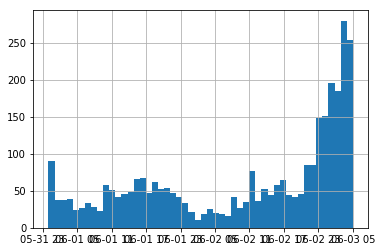

In [9]:
text_table.date_time.hist(bins= 50)

#### Note: skewed time distribution of document, use equal no. of document for time bins.

In [10]:
print(text_table['date_time'].min())
print(text_table['date_time'].max())
text_table['time_window'] = pd.qcut(text_table['date_time'],100)
text_table['time_window'].value_counts()

2013-06-01 00:00:00.704000
2013-06-03 04:59:53.681000


(2013-06-03 01:21:45.579599872, 2013-06-03 01:31:05.217999872]    33
(2013-06-01 05:59:11.477560064, 2013-06-01 07:19:41.688999936]    33
(2013-06-02 14:40:34.414040064, 2013-06-02 15:23:35.004999936]    33
(2013-06-03 04:54:17.649080064, 2013-06-03 04:59:53.680999936]    32
(2013-06-01 23:44:28.395399936, 2013-06-02 01:05:55.168519936]    32
(2013-06-02 23:02:52.652080128, 2013-06-02 23:15:17.611040]       32
(2013-06-02 22:35:31.613280, 2013-06-02 22:54:52.357560064]       32
(2013-06-02 21:14:21.811640064, 2013-06-02 21:52:02.623080192]    32
(2013-06-02 19:55:53.497799936, 2013-06-02 20:34:21.487160064]    32
(2013-06-02 17:36:27.529600, 2013-06-02 18:15:59.527800064]       32
(2013-06-02 12:27:57.829359872, 2013-06-02 13:11:32.545799936]    32
(2013-06-02 10:51:34.677760, 2013-06-02 11:21:52.039800064]       32
(2013-06-02 07:53:45.883680, 2013-06-02 08:35:48.616000]          32
(2013-06-02 03:02:08.103200, 2013-06-02 04:28:21.894000128]       32
(2013-06-01 21:30:12.949199872, 20

In [11]:
text_table_by_window= text_table.groupby(['time_window'])['word_count'].sum().to_frame()

### Calculate normalized frequency for each word (frequency = count/total words)

In [12]:
# calculate unconditional frequency in full period

full_dict = text_table.word_count.sum()

#full_dict
full_dict_frequency = full_dict

full_dict_count = sum(full_dict.values(),0.0)

for key in full_dict_frequency:
    full_dict_frequency[key]= full_dict[key]/full_dict_count

In [13]:
# calcualte frequency in each time window

text_table_by_window['total_words'] = text_table_by_window.word_count.apply(lambda x: sum(list(x.values()),0.0))

text_table_by_window['word_frequency']= text_table_by_window['word_count'].apply(lambda x: x.copy())

for i in range(text_table_by_window.shape[0]):
    for key in text_table_by_window['word_frequency'].iloc[i]:
        text_table_by_window['word_frequency'].iloc[i][key]= \
        text_table_by_window['word_frequency'].iloc[i][key]/text_table_by_window['total_words'].iloc[i]        

In [14]:
# calculate relative frequency in each window vs. full period

text_table_by_window['relative_frequency'] = text_table_by_window['word_frequency'].apply(lambda x: x.copy())

for i in range(text_table_by_window.shape[0]):
    for key in text_table_by_window['relative_frequency'].iloc[i]:
        text_table_by_window['relative_frequency'].iloc[i][key]= \
        text_table_by_window['relative_frequency'].iloc[i][key]/full_dict_frequency[key]    

In [15]:
text_table_by_window

,word_count,total_words,word_frequency,relative_frequency
time_window,,,,
"(2013-06-01 00:00:00.703999999, 2013-06-01 00:12:48.182799872]","{'mercator': 2, 'minerals': 2, 'announces': 3,...",3394.0,"{'mercator': 0.0005892751915144372, 'minerals'...","{'mercator': 84.2575132586918, 'minerals': 28...."
"(2013-06-01 00:12:48.182799872, 2013-06-01 00:37:52.000039936]","{'anheuser': 2, 'busch': 3, 'inbev': 3, 'sa': ...",2230.0,"{'anheuser': 0.0008968609865470852, 'busch': 0...","{'anheuser': 128.23766816143498, 'busch': 128...."
"(2013-06-01 00:37:52.000039936, 2013-06-01 01:07:57.614840064]","{'adds': 1, 'details': 2, 'tornado': 18, 'okla...",2404.0,"{'adds': 0.00041597337770382697, 'details': 0....","{'adds': 0.929343022046589, 'details': 1.99925..."
"(2013-06-01 01:07:57.614840064, 2013-06-01 01:57:57.029240064]","{'reuters': 25, 'linn': 1, 'energy': 6, 'lineo...",2912.0,"{'reuters': 0.008585164835164836, 'linn': 0.00...","{'reuters': 1.2687853167504333, 'linn': 98.203..."
"(2013-06-01 01:57:57.029240064, 2013-06-01 03:02:55.562400]","{'june': 8, 'infostrada': 4, 'sports': 4, 'sco...",2591.0,"{'june': 0.0030876109610189118, 'infostrada': ...","{'june': 0.633857937202138, 'infostrada': 3.47..."
"(2013-06-01 03:02:55.562400, 2013-06-01 03:50:58.106840064]","{'update': 4, '4baseball': 1, 'results': 4, 'j...",2236.0,"{'update': 0.0017889087656529517, '4baseball':...","{'update': 1.7762994434506065, '4baseball': 42..."
"(2013-06-01 03:50:58.106840064, 2013-06-01 05:01:08.552719872]","{'note': 2, 'volume': 2, 'includes': 4, 'overn...",2462.0,"{'note': 0.0008123476848090983, 'volume': 0.00...","{'note': 1.591144297430533, 'volume': 4.148340..."
"(2013-06-01 05:01:08.552719872, 2013-06-01 05:59:11.477560064]","{'correctedmitsubishi': 1, 'buy': 1, 'grain': ...",2819.0,"{'correctedmitsubishi': 0.000354735721887194, ...","{'correctedmitsubishi': 101.44377438808087, 'b..."
"(2013-06-01 05:59:11.477560064, 2013-06-01 07:19:41.688999936]","{'reuters': 30, 'sports': 6, 'schedule': 3, 'g...",2293.0,"{'reuters': 0.013083296990841693, 'sports': 0....","{'reuters': 1.9335557831891468, 'sports': 2.99..."


### For each window: 1. Filter words that have higher than average frequency in full sample; 2. Identify words that have increase relative frequency in the last three time windows (including current)

In [16]:
text_table_by_window['relative_frequency_filtered'] = text_table_by_window['relative_frequency'].apply(lambda x: x.copy())

for i in range(text_table_by_window.shape[0]):
    for k, v in text_table_by_window['relative_frequency_filtered'].iloc[i].copy().items(): 
        if v <= 1.0 :
            del text_table_by_window['relative_frequency_filtered'].iloc[i][k]        

text_table_by_window['relative_frequency_filtered'].iloc[0]

Counter({'mercator': 84.2575132586918,
         'minerals': 28.085837752897266,
         'announces': 8.42575132586918,
         'senior': 2.3734510777096283,
         'management': 2.808583775289727,
         'changes': 1.0030656340320452,
         'skorea': 7.17085219222909,
         'says': 1.144803169275704,
         'trade': 1.9825297237339248,
         'balance': 1.7738423843935118,
         'provisional': 8.86921192196756,
         'bln': 4.8844935222430035,
         'vs': 9.233700083144306,
         'revised': 11.234335101158907,
         'april': 1.4485532365391143,
         'exports': 6.95704237915804,
         'pct': 2.0168021790644315,
         'yr': 24.073575216769086,
         'earlier': 5.211804943836607,
         'reuters': 1.088598362515398,
         'poll': 3.663370141682253,
         'imports': 8.547863663925256,
         'avg': 3.829886966304173,
         'working': 3.2406735868727616,
         'day': 2.612636070036955,
         'aprilreuters': 84.2575132586918,
   

In [17]:
text_table_by_window['result'] = text_table_by_window['total_words'].apply(lambda x: list())

for i in range(2,text_table_by_window.shape[0]):
    for k, v in  text_table_by_window['relative_frequency_filtered'].iloc[i].copy().items():
        if k in text_table_by_window['relative_frequency_filtered'].iloc[i-1]:
            if (v > text_table_by_window['relative_frequency_filtered'].iloc[i-1][k]):
                if k in text_table_by_window['relative_frequency_filtered'].iloc[i-2]:
                    if (text_table_by_window['relative_frequency_filtered'].iloc[i-1][k] > text_table_by_window['relative_frequency_filtered'].iloc[i-2][k]):
                        text_table_by_window['result'].iloc[i].append(k)

### Spot check and save results to excel

In [18]:
text_table_by_window['result'].apply(lambda x: len(x))

time_window
(2013-06-01 00:00:00.703999999, 2013-06-01 00:12:48.182799872]     0
(2013-06-01 00:12:48.182799872, 2013-06-01 00:37:52.000039936]     0
(2013-06-01 00:37:52.000039936, 2013-06-01 01:07:57.614840064]    10
(2013-06-01 01:07:57.614840064, 2013-06-01 01:57:57.029240064]     1
(2013-06-01 01:57:57.029240064, 2013-06-01 03:02:55.562400]        6
(2013-06-01 03:02:55.562400, 2013-06-01 03:50:58.106840064]       29
(2013-06-01 03:50:58.106840064, 2013-06-01 05:01:08.552719872]    16
(2013-06-01 05:01:08.552719872, 2013-06-01 05:59:11.477560064]     7
(2013-06-01 05:59:11.477560064, 2013-06-01 07:19:41.688999936]    18
(2013-06-01 07:19:41.688999936, 2013-06-01 08:24:46.328600064]    55
(2013-06-01 08:24:46.328600064, 2013-06-01 09:52:36.634560]       25
(2013-06-01 09:52:36.634560, 2013-06-01 10:07:04.633560064]        2
(2013-06-01 10:07:04.633560064, 2013-06-01 11:00:00.669760]        5
(2013-06-01 11:00:00.669760, 2013-06-01 11:32:06.976599808]        6
(2013-06-01 11:32:06.9

In [19]:
print(text_table_by_window.result.iloc[9])

['nearly', 'end', 'reporting', 'messaging', 'union', 'strike', 'early', 'known', 'domestic', 'editing', 'mlb', 'games', 'caps', 'cubs', 'arizona', 'baltimore', 'detroit', 'bay', 'ny', 'boston', 'milwaukee', 'philadelphia', 'cincinnati', 'pittsburgh', 'mets', 'atlanta', 'texas', 'kansas', 'seattle', 'minnesota', 'la', 'dodgers', 'colorado', 'innings', 'angels', 'oakland', 'white', 'sox', 'baseballresults', 'scheduled', 'john', "o'brien", 'eastern', 'got', 'weeks', 'included', 'alex', 'hundreds', 'largest', 'output', 'attempted', 'shoulder', 'problems', 'clear', 'medical']


In [20]:
# Save trend word list in each time window
writer = pd.ExcelWriter('Output.xlsx')
text_table_by_window.result.to_excel(writer,'Sheet1')


In [21]:
# Save total appearance in full period for each trending word
trend_word_dict = text_table_by_window.result.apply(lambda x: Counter(x)).sum()

trend_word_list = pd.DataFrame.from_dict(trend_word_dict,orient ='index', columns=['Appearance']).sort_values(by=['Appearance'], ascending = False)

trend_word_list.to_excel(writer,'Sheet2')

In [22]:
trend_word_dict

Counter({'emergency': 2,
         'declared': 1,
         'service': 2,
         'watch': 4,
         'thursday': 2,
         'known': 2,
         'unit': 1,
         'april': 1,
         'accident': 1,
         'changes': 1,
         'deal': 3,
         'development': 1,
         'official': 2,
         'orders': 1,
         'future': 2,
         'river': 1,
         'included': 5,
         'home': 3,
         'team': 1,
         'chicago': 1,
         'arizona': 2,
         'large': 1,
         'small': 3,
         'including': 2,
         'details': 4,
         'coming': 3,
         'pushing': 2,
         'ensure': 2,
         'failed': 2,
         'law': 1,
         'comments': 2,
         'allow': 2,
         'illinois': 1,
         'compared': 1,
         'received': 3,
         'cars': 2,
         'winds': 1,
         'lisa': 1,
         'york': 4,
         'help': 3,
         'ill': 1,
         'joanne': 1,
         'alroth': 1,
         'karen': 1,
         'pierog': 1,
      

In [24]:
# Save time window for each trending word
trend_word_list_by_time_window = dict()
for key in trend_word_dict.keys():
        trend_word_list_by_time_window[key] = \
        list(text_table_by_window[text_table_by_window.result.apply(lambda x: key in x )].index)

trend_word_window_list = pd.DataFrame.from_dict(trend_word_list_by_time_window, orient ='index',\
                       columns=['w1','w2','w3','w4','w5','w6','w7'])

trend_word_window_list.to_excel(writer,'Sheet3')

In [25]:
writer.save()

### Sanity Check

In [26]:
text_table_by_window['trending_words'] = text_table_by_window['result'].apply(len)

In [27]:
text_table_by_window.columns

Index(['word_count', 'total_words', 'word_frequency', 'relative_frequency',
       'relative_frequency_filtered', 'result', 'trending_words'],
      dtype='object')

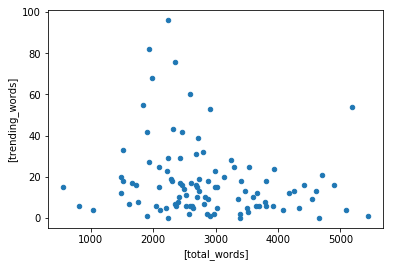

In [28]:
text_table_by_window.plot.scatter(x= ['total_words'], y = ['trending_words'])


#### Results not correlated with the number of total words in each window. 
#### As shown below, there is no clear clustering in time blocks either.

In [29]:
text_table_by_window[text_table_by_window['trending_words']>40]['trending_words']

time_window
(2013-06-01 07:19:41.688999936, 2013-06-01 08:24:46.328600064]    55
(2013-06-01 12:09:43.110599936, 2013-06-01 13:05:45.506720]       68
(2013-06-01 15:36:22.736800, 2013-06-01 16:03:01.687920128]       42
(2013-06-02 16:55:36.439680, 2013-06-02 17:36:27.529600]          82
(2013-06-02 21:14:21.811640064, 2013-06-02 21:52:02.623080192]    54
(2013-06-03 01:53:27.520760064, 2013-06-03 02:03:01.401680128]    96
(2013-06-03 02:03:01.401680128, 2013-06-03 02:20:51.619800064]    43
(2013-06-03 02:43:14.907599872, 2013-06-03 02:52:43.832960]       60
(2013-06-03 02:52:43.832960, 2013-06-03 02:57:06.627360]          76
(2013-06-03 03:08:38.972559872, 2013-06-03 03:15:57.534599936]    42
(2013-06-03 03:40:24.622000128, 2013-06-03 03:46:13.639240192]    53
Name: trending_words, dtype: int64

### Immediate Improvement:
1. Add bigram to improve word group
2. Clean for Synonyms 
3. Combine with NLP topic modelling- instead of "words", use "topic"
4. Finer treatment of words in title vs. words in main text (words in title should be given more weight)